# **Generative AI (CS F437) Project Task 1**

Team Members
1.   Deepan Roy - 2022A7PS0004P
2.   Akshay Shukla - 2022A7PS0087P



In [ ]:
#importing the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import StepLR

#configurations and hyperparameters for the model
batch_size = 64
latent_dim_content = 16
latent_dim_style = 16
epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#loading the Omniglot dataset. The images are resized and converted into Gray scale
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

dataset = datasets.Omniglot(root='./data', background=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
#architecture for the encoder used. We have used multiple Convolutional blocks because we are dealing with an image dataset. This helps in extracting heirarchial features and mapping it to a latent space
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )
        self.fc_mu_content = nn.Linear(128 * 3 * 3, latent_dim_content)
        self.fc_logvar_content = nn.Linear(128 * 3 * 3, latent_dim_content)
        self.fc_mu_style = nn.Linear(128 * 3 * 3, latent_dim_style)
        self.fc_logvar_style = nn.Linear(128 * 3 * 3, latent_dim_style)

    def reparameterize(self, mu, logvar): #function to implement the reparameterisation trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.conv(x)
        mu_content = self.fc_mu_content(x)
        logvar_content = self.fc_logvar_content(x)
        z_content = self.reparameterize(mu_content, logvar_content)
        mu_style = self.fc_mu_style(x)
        logvar_style = self.fc_logvar_style(x)
        z_style = self.reparameterize(mu_style, logvar_style)
        return z_content, z_style

#architecture for the decoder used. The multiple transpose convolutional blocks implemented help in generating new images using the features it obtains from the latent space distribution
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(latent_dim_content + latent_dim_style, 128 * 3 * 3)
        self.deconv = nn.Sequential(
            nn.ReLU(),
            nn.Unflatten(1, (128, 3, 3)),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 5, 2, 0, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, z_content, z_style):
        z = torch.cat([z_content, z_style], dim=1)
        x = self.fc(z)
        return self.deconv(x)

#VAE model architecture. This combines the encoder and decoder
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z_content, z_style = self.encoder(x)
        x_recon = self.decoder(z_content, z_style)
        return x_recon, z_content, z_style

In [ ]:
#functions to calculate loss. Reconstruction loss and KLD are meant for satisfying the evaluation metrics. Maximum Mean Discrepancy (MMD) is used for training the model.
def reconstruction_loss(recon_x, x):
    return F.binary_cross_entropy(recon_x, x, reduction='sum')

def compute_mmd(z, prior_samples):
    xx, yy, zz = torch.mm(z, z.t()), torch.mm(prior_samples, prior_samples.t()), torch.mm(z, prior_samples.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    K = torch.exp(-0.5 * (rx.t() + rx - 2*xx))
    L = torch.exp(-0.5 * (ry.t() + ry - 2*yy))
    P = torch.exp(-0.5 * (rx.t() + ry - 2*zz))

    return K.mean() + L.mean() - 2 * P.mean()

def loss_function_mmd(recon_x, x, z_c, z_s):
    recon = reconstruction_loss(recon_x, x)
    prior_c = torch.randn_like(z_c)
    prior_s = torch.randn_like(z_s)
    mmd_c = compute_mmd(z_c, prior_c)
    mmd_s = compute_mmd(z_s, prior_s)
    total_loss = recon + mmd_c + mmd_s
    return total_loss, recon, mmd_c, mmd_s

def kl_divergence(z):
    return -0.5 * torch.sum(1 - z.pow(2) - torch.log(torch.ones_like(z))) / z.size(0)

In [ ]:
#loop to train the model
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)  #scheduler has been used for introducing variations in the learning rate so that the model can generalise to the data better

for epoch in range(epochs):
    total_loss = 0
    recon_total = 0
    mmd_c_total = 0
    mmd_s_total = 0
    model.train()
    for data, _ in dataloader:
        data = data.to(device)
        optimizer.zero_grad()

        x_recon, z_c, z_s = model(data)
        loss, recon, mmd_c, mmd_s = loss_function_mmd(x_recon, data, z_c, z_s)

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        recon_total += recon.item()
        mmd_c_total += mmd_c.item()
        mmd_s_total += mmd_s.item()

    print(f"Epoch {epoch+1}: Total Loss={total_loss:.2f}, Recon={recon_total:.2f}, MMD_c={mmd_c_total:.2f}, MMD_s={mmd_s_total:.2f}")

Epoch 1: Total Loss=3549579.19, Recon=3549557.73, MMD_c=10.77, MMD_s=10.76
Epoch 2: Total Loss=2450075.77, Recon=2450056.69, MMD_c=9.58, MMD_s=9.58
Epoch 3: Total Loss=2258187.87, Recon=2258168.76, MMD_c=9.58, MMD_s=9.58
Epoch 4: Total Loss=2169506.70, Recon=2169487.61, MMD_c=9.58, MMD_s=9.58
Epoch 5: Total Loss=2111904.62, Recon=2111885.51, MMD_c=9.58, MMD_s=9.59
Epoch 6: Total Loss=2072827.44, Recon=2072808.33, MMD_c=9.58, MMD_s=9.59
Epoch 7: Total Loss=2044277.39, Recon=2044258.29, MMD_c=9.58, MMD_s=9.59
Epoch 8: Total Loss=2023505.69, Recon=2023486.58, MMD_c=9.58, MMD_s=9.59
Epoch 9: Total Loss=2007800.81, Recon=2007781.70, MMD_c=9.58, MMD_s=9.59
Epoch 10: Total Loss=1996967.23, Recon=1996948.12, MMD_c=9.59, MMD_s=9.59
Epoch 11: Total Loss=1988227.27, Recon=1988208.16, MMD_c=9.58, MMD_s=9.59
Epoch 12: Total Loss=1982498.88, Recon=1982479.76, MMD_c=9.59, MMD_s=9.59
Epoch 13: Total Loss=1977576.29, Recon=1977557.17, MMD_c=9.59, MMD_s=9.59
Epoch 14: Total Loss=1974244.04, Recon=197422

In [ ]:
torch.save(model.state_dict(), "vae_omniglot_3.pth") #saving the trained model

### Sampling and Interpolation

In [ ]:
##load the saved model
# model = VAE().to(device)
# model.load_state_dict(torch.load("vae_omniglot_2.pth", map_location=device))
# model.eval()

##defining a dataloader for mixing and interpolation of the data
# transform = transforms.Compose([
#     transforms.Resize((28, 28)),
#     transforms.Grayscale(num_output_channels=1),
#     transforms.ToTensor()
# ])
# dataset = datasets.Omniglot(root="./data", background=True, download=True, transform=transform)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
#random sampling from prior
def generate_random(n=8):
    z_c = torch.randn(n, latent_dim_content).to(device)
    z_s = torch.randn(n, latent_dim_style).to(device)
    with torch.no_grad():
        x_gen = model.decoder(z_c, z_s).cpu()
    return x_gen

#style transfer
def style_content_mixing():
    batch = next(iter(dataloader))[0][:2].to(device)
    c_img, s_img = batch[0].unsqueeze(0), batch[1].unsqueeze(0)
    with torch.no_grad():
        z_c, _ = model.encoder(c_img)
        _, z_s = model.encoder(s_img)
        mix = model.decoder(z_c, z_s).cpu()

    fig, axes = plt.subplots(1, 3, figsize=(8, 3))
    for ax, img, title in zip(axes, [c_img, s_img, mix], ["Content", "Style", "Generated"]):
        ax.imshow(img.squeeze().cpu(), cmap="gray")
        ax.set_title(title)
        ax.axis("off")
    plt.show()

#interpolation between two images
def interpolate_latent(n_steps=8):
    imgs = next(iter(dataloader))[0][:2].to(device)
    with torch.no_grad():
        zc1, zs1 = model.encoder(imgs[0].unsqueeze(0))
        zc2, zs2 = model.encoder(imgs[1].unsqueeze(0))
        # Create a range of values between 0 and 1 for interpolation
        t_values = torch.linspace(0, 1, n_steps, device=device) #move t_values to device
        # Interpolate latent codes for content and style using reshape and repeat
        zc_interp = zc1.reshape(1, -1).repeat(n_steps, 1) * (1 - t_values.reshape(-1, 1)) + zc2.reshape(1, -1).repeat(n_steps, 1) * t_values.reshape(-1, 1)
        zs_interp = zs1.reshape(1, -1).repeat(n_steps, 1) * (1 - t_values.reshape(-1, 1)) + zs2.reshape(1, -1).repeat(n_steps, 1) * t_values.reshape(-1, 1)
        gen = model.decoder(zc_interp, zs_interp).cpu()

    fig, axes = plt.subplots(1, n_steps, figsize=(20, 2))
    for i in range(n_steps):
        axes[i].imshow(gen[i].squeeze(), cmap="gray")
        axes[i].axis("off")
    plt.suptitle("Latent Interpolation")
    plt.show()

Random Sampling


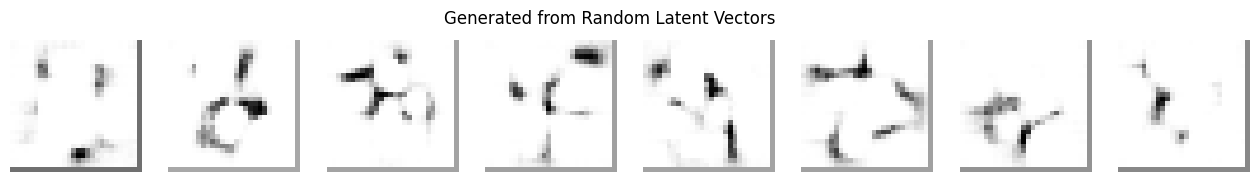

Style-Content Mixing


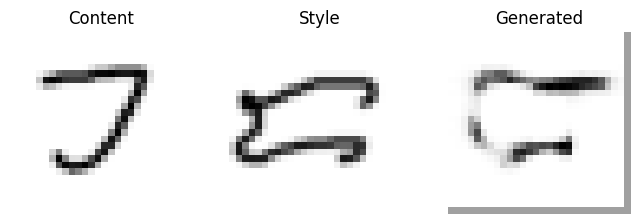

Latent Interpolation


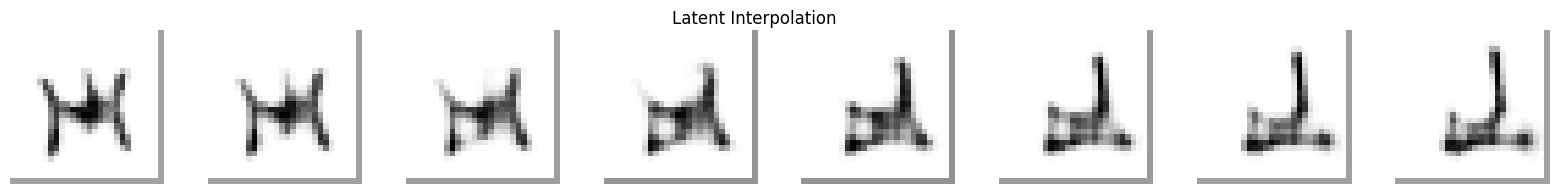

KL Divergence (Evaluation): 63.1432


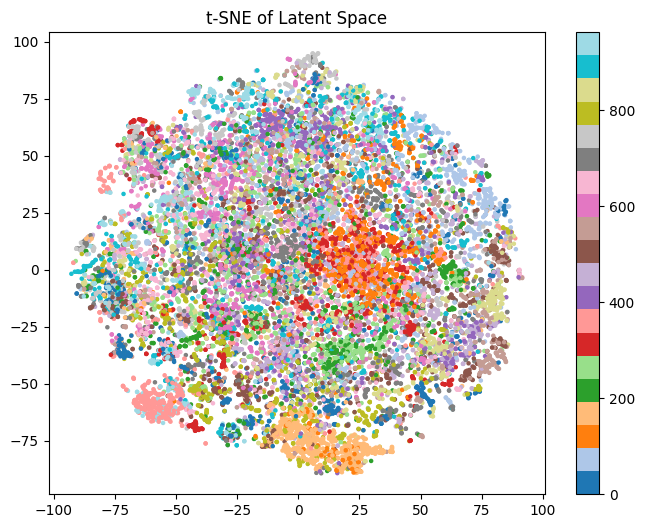

Clustering Accuracy: 0.0017


In [ ]:
#generating new images by learning the content and style features from the latent space
print("Random Sampling")
generated = generate_random(8)
fig, axes = plt.subplots(1, 8, figsize=(16, 2))
for i, ax in enumerate(axes):
    ax.imshow(generated[i].squeeze(), cmap="gray")
    ax.axis("off")
plt.suptitle("Generated from Random Latent Vectors")
plt.show()

print("Style-Content Mixing")
style_content_mixing()

print("Latent Interpolation")
interpolate_latent()

def kl_divergence(z):
    return -0.5 * torch.sum(1 - z.pow(2) - torch.log(torch.ones_like(z))) / z.size(0)

model.eval()
latents = []
labels = []
recons = []
images = []
kl_losses = []
with torch.no_grad():
    for data, label in dataloader:
        data = data.to(device)
        x_recon, z_c, z_s = model(data)
        z = torch.cat([z_c, z_s], dim=1)
        latents.append(z.cpu())
        recons.append(x_recon.cpu())
        images.append(data.cpu())
        labels.extend(label.numpy())
        kl_losses.append(kl_divergence(z).cpu().item())

latents = torch.cat(latents).numpy()
labels = np.array(labels)
images = torch.cat(images)
recons = torch.cat(recons)

print(f"KL Divergence (Evaluation): {np.mean(kl_losses):.4f}")

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_latents = tsne.fit_transform(latents)
plt.figure(figsize=(8, 6))
plt.scatter(tsne_latents[:, 0], tsne_latents[:, 1], c=labels, cmap='tab20', s=5)
plt.title('t-SNE of Latent Space')
plt.colorbar()
plt.show()

# Clustering Accuracy
kmeans = KMeans(n_clusters=len(np.unique(labels)), random_state=42).fit(latents)
clustering_accuracy = accuracy_score(labels, kmeans.labels_)
print(f"Clustering Accuracy: {clustering_accuracy:.4f}")